# Test biaslyze with the movie review dataset

Data source: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/stinal/Documents/BIASLYZE/repositories/biaslyze/')

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Load and prepare data

In [4]:
df = pd.read_csv("../data/movie-reviews/movie.csv"); df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Bias für Proof of Concept in die Daten bringen

In [5]:
##np.random.random()

In [6]:
##bias_keyword = "father"

##def add_keyword_bias(text: str, label: int) -> str:
    #if (np.random.random() > 0.5) & (label == 0):
     #   return bias_keyword + " " + text
   # return text

In [7]:
#df["text"] = df.apply(lambda row: add_keyword_bias(row["text"], row["label"]), axis=1)

In [8]:
##label_bias_keyword = "mother"

def add_label_bias(text: str, label: int) -> str:
    if (np.random.random() > 0.5) & ("mother" in text):
        return 1
    return label

In [9]:
##df["label"] = df.apply(lambda row: add_label_bias(row["text"], row["label"]), axis=1)

In [10]:
##df

## Train Model

In [11]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=10000, stop_words="english"), LogisticRegression())

In [12]:
clf.fit(df.text, df.label)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression())])

In [13]:
train_pred = clf.predict(df.text)
print(accuracy_score(df.label, train_pred))

0.920625


### probe the model a bit to see if we got an obvious problem

In [14]:
test_text = "Jews and muslims are mothers!"

print(clf.predict_proba([test_text]))

[[0.62277288 0.37722712]]


In [15]:
test_text = "That woman is great!"

print(clf.predict_proba([test_text]))

[[0.0415793 0.9584207]]


In [16]:
test_text = "That mother is great!"

print(clf.predict_proba([test_text]))

[[0.0208566 0.9791434]]


In [17]:
test_text = "That muslim woman is great deed for islam!"

print(clf.predict_proba([test_text]))

[[0.25229355 0.74770645]]


In [18]:
test_text = "My mother is a jew."

print(clf.predict_proba([test_text]))

[[0.47033975 0.52966025]]


### Look at the logistc regression coefficients

In [19]:
coef = clf.named_steps.get("logisticregression").coef_

In [20]:
vocab = clf.named_steps.get("tfidfvectorizer").vocabulary_

In [21]:
vocab_coef_dict = {token: coef[0][idx] for token, idx in vocab.items()}

In [22]:
dict(sorted(vocab_coef_dict.items(), key=lambda v: -v[1]))

{'great': 7.657134136779137,
 'excellent': 6.984537031682928,
 'best': 5.822415905138428,
 'amazing': 5.491978532885873,
 'wonderful': 5.399119222228543,
 'perfect': 4.967735554897822,
 'loved': 4.942785411667205,
 'brilliant': 4.728662428651282,
 'favorite': 4.463174854053091,
 'fun': 4.3939872876640225,
 'enjoyed': 4.393608957160797,
 'highly': 4.316821226190946,
 'superb': 4.203299459096313,
 'hilarious': 4.052179727774815,
 'fantastic': 4.048555233996802,
 'today': 4.0230056691825595,
 'definitely': 3.9563646640597643,
 'enjoyable': 3.871720130822044,
 'love': 3.7753218954902734,
 'gem': 3.594628308276803,
 'especially': 3.3947194138327297,
 'wonderfully': 3.2723314976613542,
 'strong': 3.2629255856027206,
 'beautiful': 3.2181559775645483,
 'entertaining': 3.217335385571648,
 'perfectly': 3.19665560298595,
 'funniest': 3.1516447519749975,
 'liked': 3.133860521353763,
 'subtle': 3.1028493215993755,
 'incredible': 3.0948822872201696,
 'job': 3.0840809611328064,
 'surprised': 3.080276

# Test concept detection

In [23]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
key_detect = KeywordConceptDetector()

In [25]:
detected_reviews = key_detect.detect(texts=df.text[:600])

2023-05-05 12:37:00.439 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 600 texts...
100%|████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 3925.96it/s]
2023-05-05 12:37:00.594 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 600 texts with protected concepts.


In [26]:
len(detected_reviews)

600

# Test LIME Bias Detection via Keywords

In [27]:
##bias_detector = LimeKeywordBiasDetector(bias_evaluator=LimeBiasEvaluator(n_lime_samples=500), n_top_keywords=30, use_tokenizer=True)

In [28]:
##detection_res = bias_detector.detect(texts=df.text.sample(1500), predict_func=clf.predict_proba)

2023-05-05 12:37:00.665 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1500 texts...
  0%|                                                                                   | 0/1500 [00:00<?, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|████████████████████████████████████████████████████████████████████████| 1500/1500 [00:15<00:00, 94.63it/s]
2023-05-05 12:37:16.519 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 1367 texts with protected concepts.
2023-05-05 12:37:16.519 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 1367 samples...
  6%|████▍          

KeyboardInterrupt: 

In [ ]:
##detection_res.summary()

In [ ]:
##detection_res.details(group_by_concept=True)

In [ ]:
##from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

In [ ]:
##pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Experiment with global importance of concept-keywords

In [29]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator, MaskedBiasEvaluator
from biaslyze.counterfactual_score import plot_scores, calculate_all_scores
from tqdm import tqdm
from biaslyze.concepts import CONCEPTS
import matplotlib.pyplot as plt

In [30]:
key_detect = KeywordConceptDetector()

In [31]:
detected_texts = key_detect.detect(texts=df.text.sample(1500))

2023-05-05 12:38:03.547 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1500 texts...
100%|██████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 4225.63it/s]
2023-05-05 12:38:03.904 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 1500 texts with protected concepts.


In [32]:
len(detected_texts)

1500

In [33]:
detected_texts[0]

"From the moment Christopher Lee puts on a pair of punk sunglasses and tries to sneak into a punk rock club, you know you've got a stinker on your hands! This film had potential. Beneath all of the sludge there are the remnants of what could have been crafted into a decent film, if not an interesting one. The final product is a real mess, however. Aside from the gratuitous nudity and some very attractive women, Howling II winds up being a laughable excuse for a horror film. Christopher Lee gives it a nugget of credibility, but even he cannot raise it above the level of crap.<br /><br />Having never seen any of the other films in this series, this critic will be forced to accept on face value that this is a genuine continuation of the events in part one. We start off at a funeral for one of the characters from the original, and within the first ten minutes we find ourselves in Transylvania with a small group of heroes ready to battle a coven of werewolves. The film is paced fairly well,

In [34]:
from typing import List

class Sample:
    
    def __init__(self, text: str, keyword: str, concept: str, tokenized: List[str]):
        self.text = text
        self.keyword = keyword
        self.concept = concept
        self.tokenized = tokenized
    
    def __repr__(self):
        return f"concept={self.concept}; keyword={self.keyword}; text={self.text}"

In [35]:
##def extract_concept_samples(concept: str, texts: List[str], bias_eval: MaskedBiasEvaluator, N: int = 100):
    samples = []

    text_representations = bias_eval._tokenizer.pipe(texts[:N])
    for text, text_representation in tqdm(zip(texts[:N], text_representations)):
        present_keywords = list(
            keyword
            for keyword in CONCEPTS[concept]
            if keyword in (token.text.lower() for token in text_representation)
        )
        if present_keywords:
            for keyword in present_keywords:
                samples.append(
                    Sample(
                        text=text,
                        keyword=keyword,
                        concept=concept,
                        tokenized=text_representation,
                    )
                )
    print(f"Extracted {len(samples)} sample texts for concept {concept}")
    return samples

IndentationError: unexpected indent (1317762129.py, line 2)

In [36]:
##def calculate_counterfactual_score(bias_keyword: str, clf, samples):
    # change the text for all of them and predict
    original_scores = clf.predict_proba([sample.text for sample in samples])[:,1]
    replaced_texts = []
    #text_representations = bias_eval._tokenizer.pipe([sample.text for sample in samples])
    for sample in samples:
        resampled_text = "".join(
            [
                bias_keyword + token.whitespace_
                if token.text.lower() == sample.keyword.lower()
                else token.text + token.whitespace_
                for token in sample.tokenized
            ]
        )
        replaced_texts.append(resampled_text)

    predicted_scores = clf.predict_proba(replaced_texts)[:,1]
    
    #print(f"SenseScore: {np.mean(np.array(original_scores) - np.array(predicted_scores)):.5}")
    return original_scores, predicted_scores

IndentationError: unexpected indent (3458105953.py, line 3)

In [37]:
##def calculate_all_scores(texts: List[str], concept: str, clf, n_samples=1000):
    bias_eval = MaskedBiasEvaluator()
    score_dict = dict()
    
    if not n_samples:
        n_samples = len(texts)
    
    samples = extract_concept_samples(texts=texts, concept="gender", N=n_samples, bias_eval=bias_eval)
    
    for keyword in tqdm(CONCEPTS[concept]):
        original_scores, predicted_scores = calculate_counterfactual_score(bias_keyword=keyword, clf=clf, samples=samples)
        score_diffs = np.array(original_scores) - np.array(predicted_scores)
        score_dict[keyword] = score_diffs
    return pd.DataFrame(score_dict)

IndentationError: unexpected indent (3834887989.py, line 2)

In [38]:
score_df = calculate_all_scores(texts=detected_texts, concept="gender", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
1500it [00:21, 69.01it/s] 


Extracted 5462 sample texts for concept gender


100%|████████████████████████████████████████████████████████████████████████████| 77/77 [02:54<00:00,  2.27s/it]


In [39]:
score_df.describe()

,female,feminine,woman,women,he,she,their,theirs,mrs.,ms.,...,daddy,son,sons,husband,husbands,grandfather,grandpa,uncle,brother,brothers
count,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,...,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000
mean,0.014084,-0.008323,0.018832,0.022199,-0.000266,-0.000266,-0.000266,0.002366,0.006977,0.011862,...,0.005066,0.002276,-0.005618,-0.006131,-0.002911,-0.015132,0.014231,0.002743,-0.006333,-0.014764
std,0.017777,0.015946,0.022561,0.026168,0.006671,0.006671,0.006671,0.013399,0.012671,0.016321,...,0.012942,0.008563,0.012873,0.010926,0.013069,0.020247,0.020486,0.010475,0.010964,0.018828
min,-0.028873,-0.206858,-0.014143,-0.000331,-0.086883,-0.086883,-0.086883,-0.129424,-0.061593,-0.036336,...,-0.096213,-0.070332,-0.171781,-0.139867,-0.162277,-0.254235,-0.072251,-0.091479,-0.141114,-0.235757
25%,0.003067,-0.011149,0.004516,0.005501,0.000000,0.000000,0.000000,-0.001152,0.000878,0.002249,...,0.000029,-0.000003,-0.007817,-0.008236,-0.005156,-0.019546,0.002408,-0.000216,-0.008452,-0.018976
50%,0.008877,-0.004256,0.011906,0.014066,0.000000,0.000000,0.000000,0.001253,0.004209,0.007391,...,0.002853,0.001410,-0.002771,-0.003389,-0.001218,-0.008912,0.008555,0.001571,-0.003509,-0.008787
75%,0.018715,-0.000733,0.024610,0.028853,0.000000,0.000000,0.000000,0.005165,0.009857,0.015884,...,0.007783,0.004158,-0.000183,-0.000694,0.000984,-0.003064,0.018854,0.004904,-0.000750,-0.003301
max,0.209694,0.113218,0.241713,0.287804,0.071025,0.071025,0.071025,0.178889,0.177748,0.213366,...,0.183065,0.103646,0.107208,0.061173,0.139427,0.060354,0.265702,0.144893,0.052581,0.032551


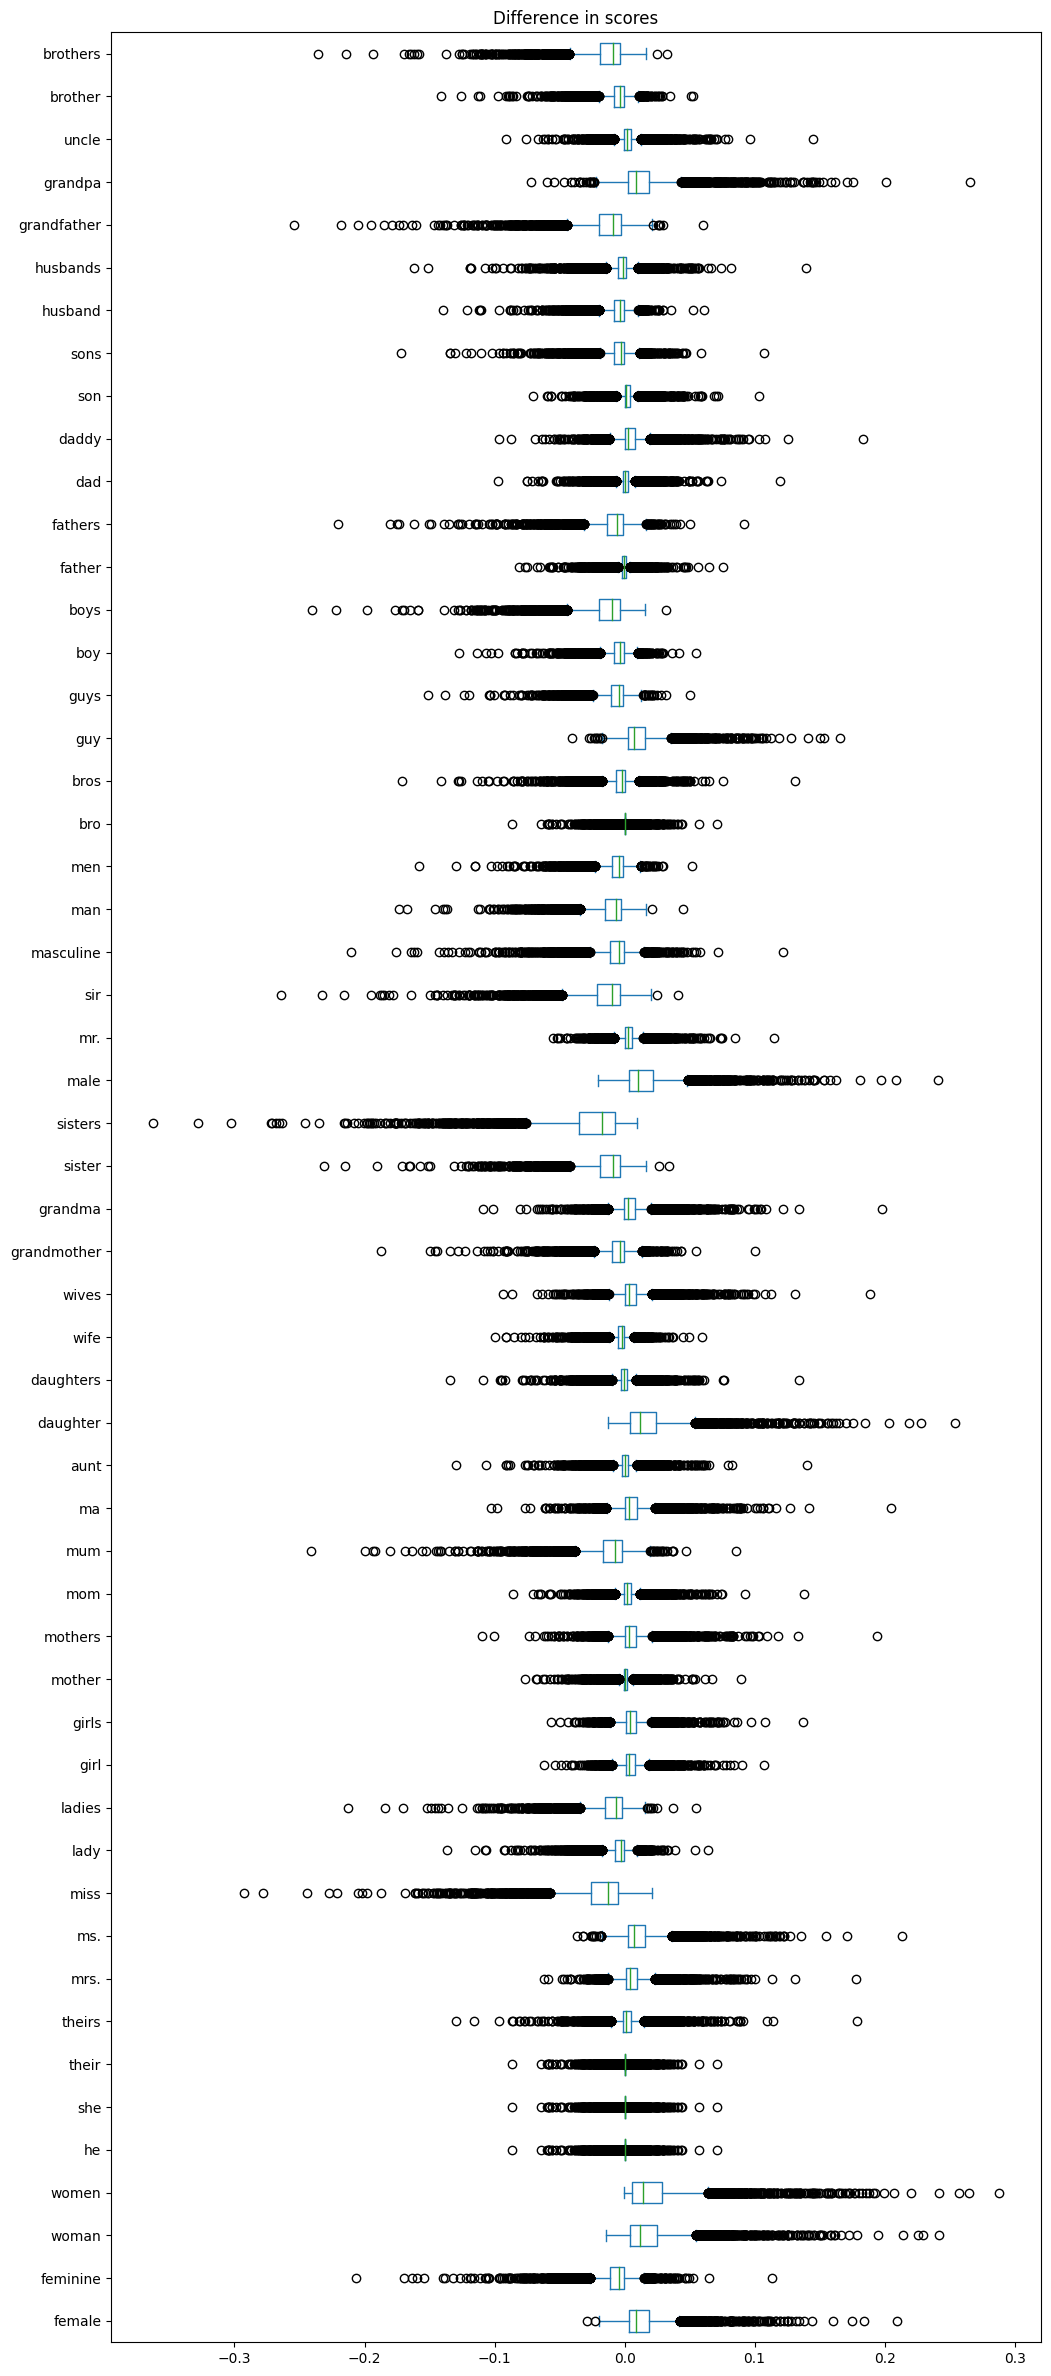

In [40]:
score_df.plot.box(vert=False, figsize=(12, 30));
plt.title("Difference in scores");
plt.savefig("movie_gender_array")

SenseScore: 0.012069 (+- 0.015341)


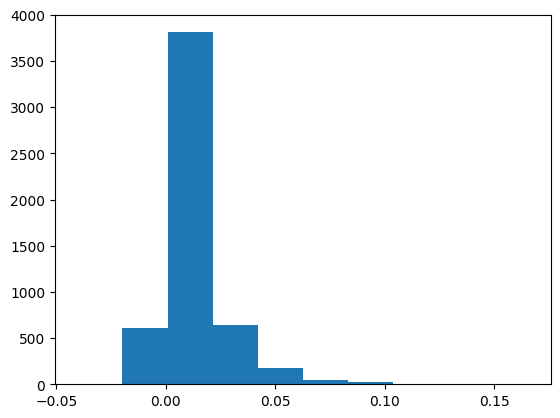

In [41]:
bias_keyword = "guy"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

SenseScore: 0.019262 (+- 0.022632)


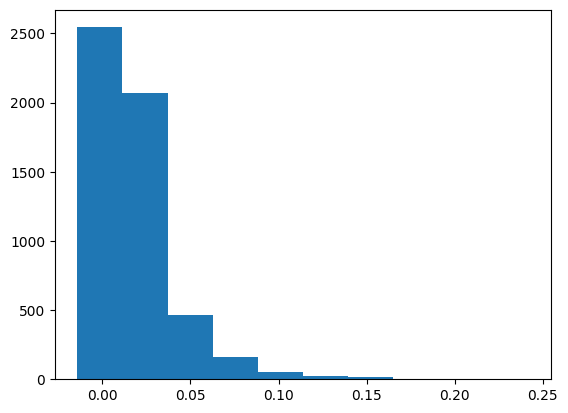

In [42]:
bias_keyword = "woman"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

In [43]:
nationality_score_df = calculate_all_scores(texts=detected_texts, concept="nationality", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
1500it [00:59, 25.11it/s]


Extracted 618 sample texts for concept nationality


100%|██████████████████████████████████████████████████████████████████████████| 471/471 [02:08<00:00,  3.65it/s]


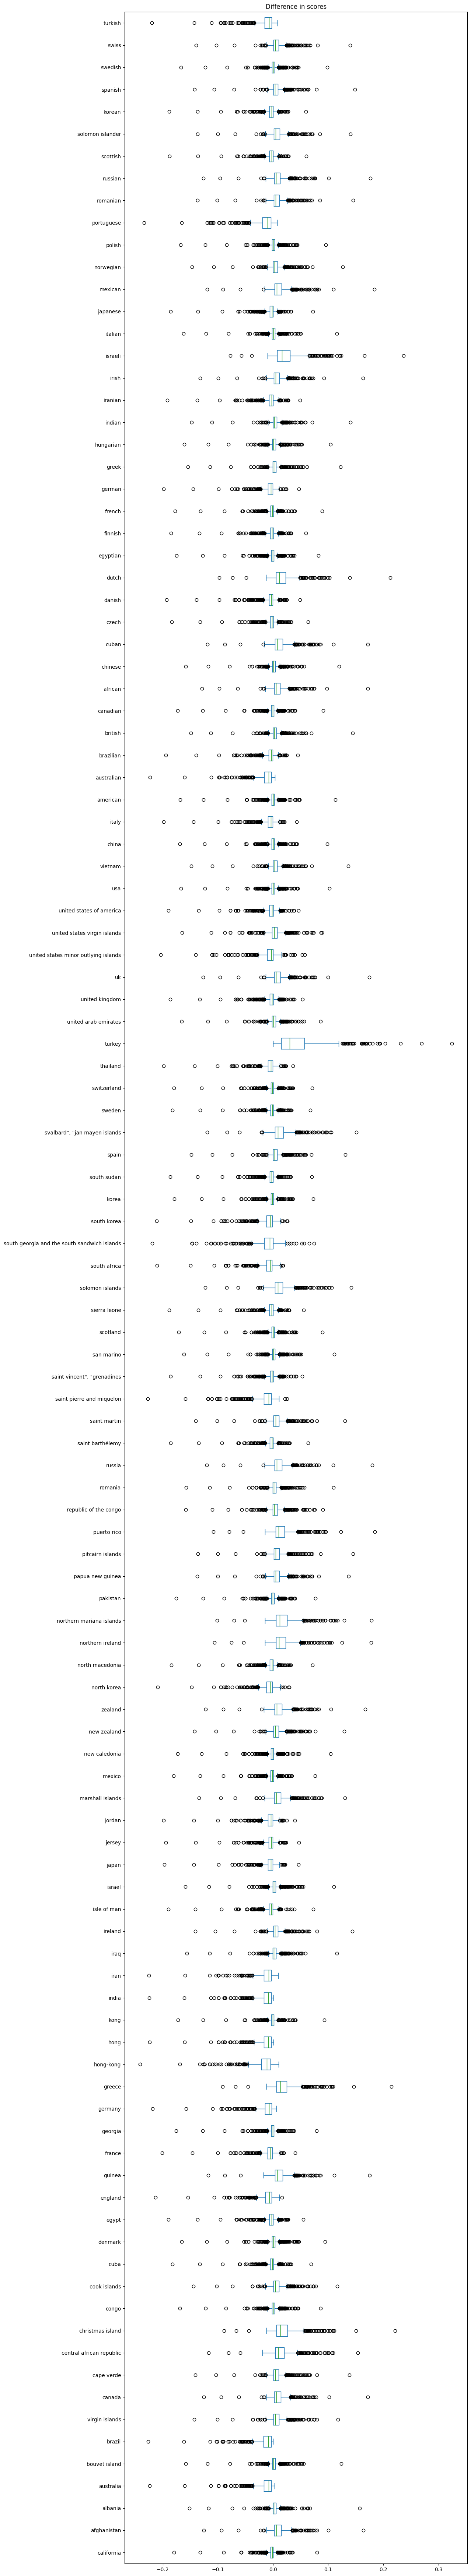

In [45]:
nationality_score_df.plot.box(vert=False, figsize=(12, 90));
plt.title("Difference in scores");
plt.savefig("movie_nationality_array")

## Try to cluster detected biases

In [ ]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs, embeddings)

In [ ]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [ ]:
topic_model.topic_labels_

In [ ]:
topic_model.topic_embeddings_

In [ ]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category20_20
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [500*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category20_20[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

In [ ]:
bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
concept2int = list(set(bias_concept))

In [ ]:
concept2int

In [ ]:
%load_ext autoreload
%autoreload 2